In [1]:
%cd /nfsd/sysbiobig/bazzaccoen/tangramlit_dev

/nfsd/sysbiobig/bazzaccoen/tangramlit_dev


In [2]:
import tangramlit as tgl

/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/myvenv/lib64/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/myvenv/lib64/python3.12/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/myvenv/lib64/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text 

In [3]:
import scanpy as sc
import numpy as np 
import matplotlib.pyplot as plt
import yaml

# Data Loading

In [4]:
# Set data path
data_path = "/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/data/Dataset2/"

In [5]:
adata_sc = sc.read(data_path + "scRNA_data.h5ad")
adata_sc

AnnData object with n_obs × n_vars = 8308 × 17376
    obs: 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells_expressed', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p', 'sparsity'

In [6]:
adata_st = sc.read(data_path + "spatial_data.h5ad")
adata_st

AnnData object with n_obs × n_vars = 3585 × 249
    obs: 'X', 'Y', 'Label', 'n_counts'
    uns: 'gearyC', 'log1p', 'moranI', 'sparsity', 'spatial_neighbors'
    obsm: 'spatial'
    obsp: 'spatial_connectivities', 'spatial_distances'

# Config

In [7]:
# Read config yaml
with open("data/Dataset2/train_config.yaml", "r") as f:
        config = yaml.safe_load(f)

config  # no cluster_label and ct_islands

{'cluster_label': None,
 'lambda_count': 1e-05,
 'lambda_ct_islands': 0,
 'lambda_d': 1,
 'lambda_f_reg': 1e-05,
 'lambda_g1': 1,
 'lambda_g2': 1,
 'lambda_geary': 1,
 'lambda_getis_ord': 1,
 'lambda_l1': 1,
 'lambda_l2': 1,
 'lambda_moran': 1,
 'lambda_neighborhood_g1': 1,
 'lambda_r': 1,
 'lambda_sparsity_g1': 0,
 'learning_rate': 0.1,
 'filter': True,
 'num_epochs': 20,
 'random_state': 42,
 'target_count': None}

# Train/val split

In [8]:
# Get shared genes (case-insensitive)
sc_genes = {gene.lower(): gene for gene in adata_sc.var_names}
st_genes = {gene.lower(): gene for gene in adata_st.var_names}

# Find intersection of lowercase gene names
shared_genes_set = set(sc_genes.keys()) & set(st_genes.keys())
shared_genes = [gene_lower for gene_lower in shared_genes_set]

# Shuffle the shared genes
shared_genes = np.array(shared_genes)
np.random.seed(config['random_state'])
np.random.shuffle(shared_genes)

# Split into train and validation
train_ratio = 0.8
n_train = int(len(shared_genes) * train_ratio)
train_genes = shared_genes[:n_train]
val_genes = shared_genes[n_train:]

print(len(train_genes), "training genes: ", train_genes[0:10], "...")
print(len(val_genes), "validation genes: ", val_genes[0:10], "...")

161 training genes:  ['elf4' 'fbll1' 'nhlh1' 'bach1' 'irx5' 'ptch1' 'atr' 'cbfa2t3' 'sp8' 'vip'] ...
41 validation genes:  ['ctnnb1' 'six4' 'elf1' 'atm' 'sncg' 'sp1' 'maml3' 'dlx2' 'cdc6' 'topors'] ...


# Warmup Run

In [9]:
config

{'cluster_label': None,
 'lambda_count': 1e-05,
 'lambda_ct_islands': 0,
 'lambda_d': 1,
 'lambda_f_reg': 1e-05,
 'lambda_g1': 1,
 'lambda_g2': 1,
 'lambda_geary': 1,
 'lambda_getis_ord': 1,
 'lambda_l1': 1,
 'lambda_l2': 1,
 'lambda_moran': 1,
 'lambda_neighborhood_g1': 1,
 'lambda_r': 1,
 'lambda_sparsity_g1': 0,
 'learning_rate': 0.1,
 'filter': True,
 'num_epochs': 20,
 'random_state': 42,
 'target_count': None}

In [10]:
ad_map, mapper, mapper_data = tgl.map_cells_to_space(
        adata_sc=adata_sc, 
        adata_st=adata_st, 
        train_genes_names=train_genes,
        val_genes_names=val_genes,
        **config,
        experiment_name="warmup_dataset3",
        )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name               | Type      | Params | Mode 
---------------------------------------------------------
0 | _density_criterion | KLDivLoss | 0      | train
  | other params       | n/a       | 29.8 M | n/a  
---------------------------------------------------------
29.8 M    Trainable params
0         Non-trainable params
29.8 M    Total params
119.170   Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode



Validating with 41 genes
S matrix shape: torch.Size([8308, 41])
G matrix shape: torch.Size([3585, 41])


Trainig:   0%|          | 0/20 [00:00<?, ?it/s]


Training with 161 genes
S matrix shape: torch.Size([8308, 161])
G matrix shape: torch.Size([3585, 161])


Trainig: 100%|██████████| 20/20 [12:46<00:00, 38.33s/it]


In [11]:
for key, values in ad_map.uns['training_history'].items():
    print(f"{key} initial values: ", values[:4])

total_loss initial values:  [53606604.0, 46411100.0, 39998600.0, 34353900.0]
main_loss initial values:  [0.9120135307312012, 0.913079559803009, 0.9142459630966187, 0.9154846668243408]
vg_reg initial values:  [0.5312348008155823, 0.5313028693199158, 0.5313758850097656, 0.5314534306526184]
kl_reg initial values:  [0.00012091081589460373, 0.00011121830902993679, 0.00010094419121742249, 9.021861478686333e-05]
entropy_reg initial values:  [-63851.26171875, -64256.59375, -64662.5703125, -65059.7578125]
l1_term initial values:  [23762808.0, 21021796.0, 18509700.0, 16250842.0]
l2_term initial values:  [29777670.0, 25322948.0, 21422318.0, 18036260.0]
sparsity_term initial values:  []
neighborhood_term initial values:  [0.9650565981864929, 0.9654500484466553, 0.965874433517456, 0.9663188457489014]
getis_ord_term initial values:  [0.9781763553619385, 0.9783784747123718, 0.9785950183868408, 0.9788206219673157]
moran_term initial values:  [0.0009328683954663575, 0.0008434685878455639, 0.00075057428

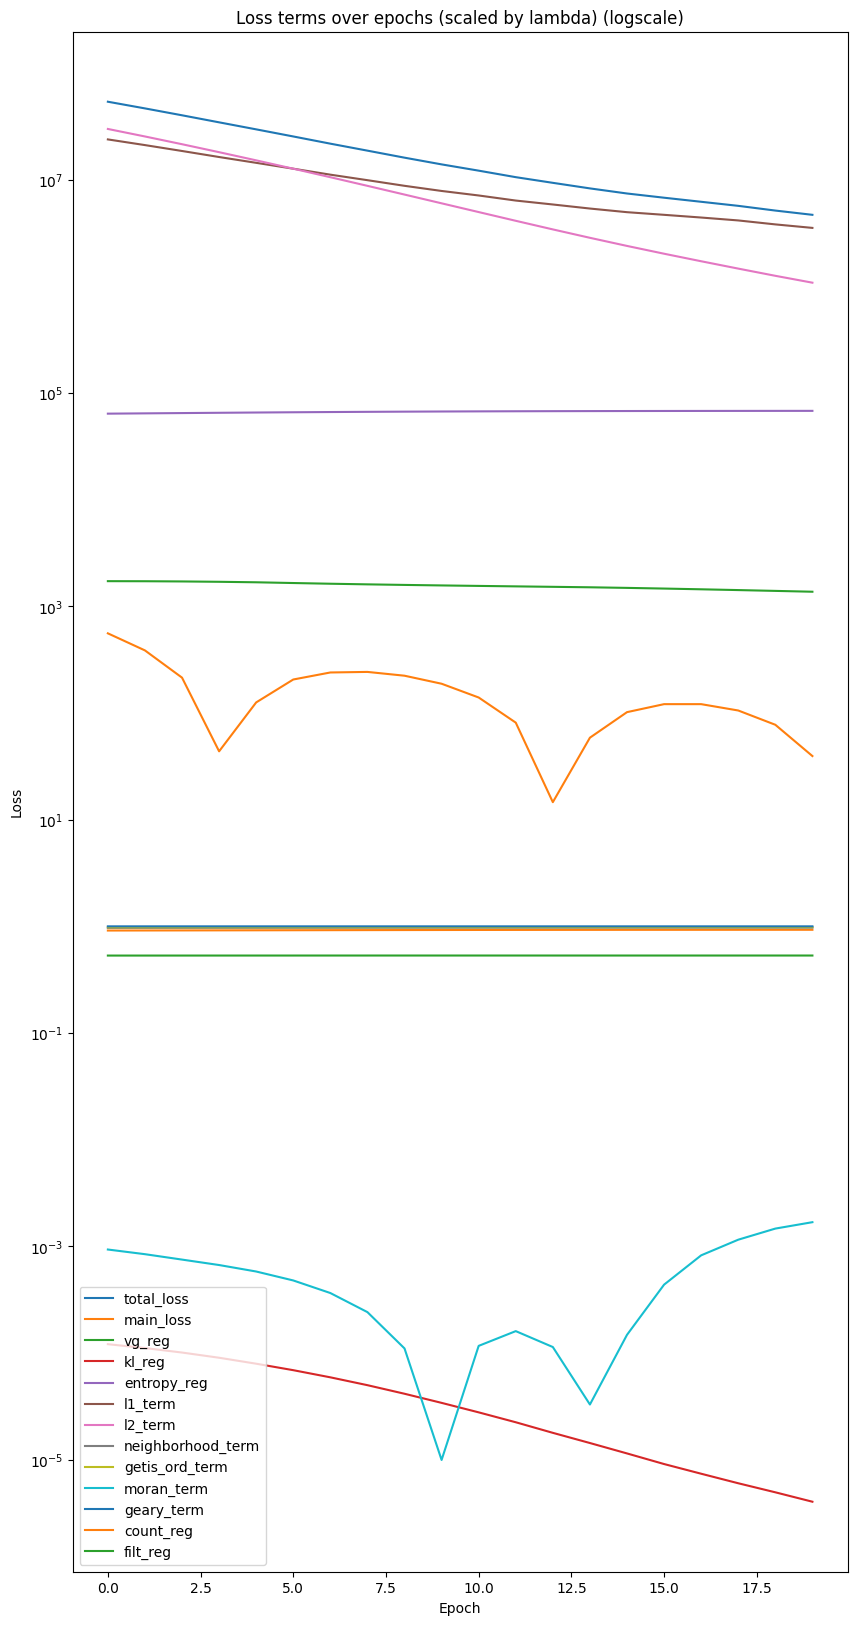

In [12]:
tgl.plot_training_history(adata_map=ad_map, hyperpams=mapper.hparams,
                   log_scale=True, lambda_scale=True, show_total_loss=True,)

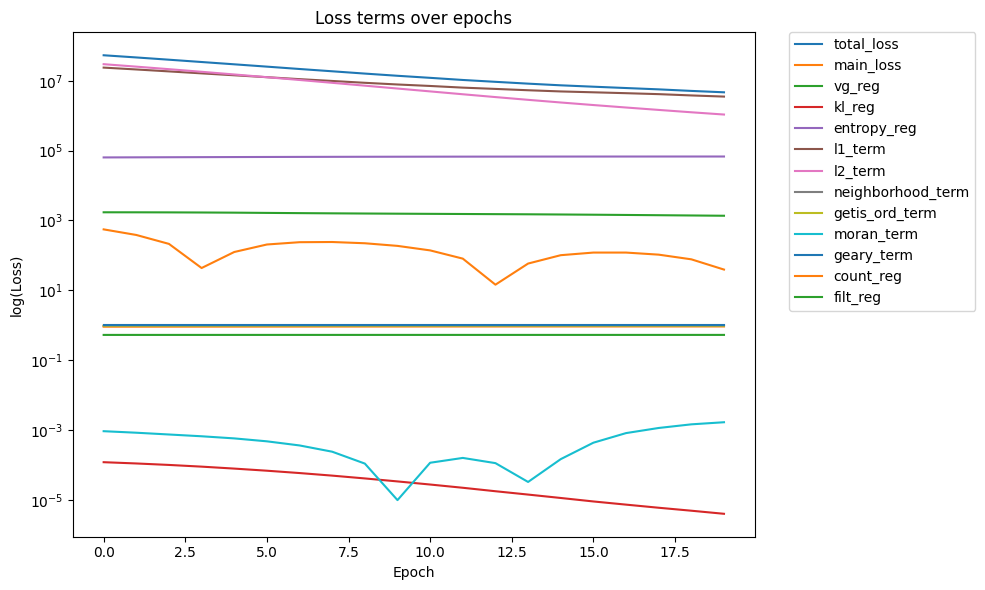

In [13]:
plt.figure(figsize=(10, 6))
title = 'Loss terms over epochs'

for key, values in ad_map.uns['training_history'].items():
    if values:
        y = np.abs(np.array(values))
        plt.semilogy(y, label=key)

plt.xlabel('Epoch')
plt.ylabel('log(Loss)')
plt.title(title)
plt.legend(
    bbox_to_anchor=(1.05, 1),  # outside on the right
    loc='upper left',
    borderaxespad=0.
)
plt.tight_layout()
plt.show()


# Model training

In [ ]:
config

{'cluster_label': 'celltype',
 'lambda_count': 1e-05,
 'lambda_ct_islands': 1,
 'lambda_d': 1,
 'lambda_f_reg': 1e-05,
 'lambda_g1': 1,
 'lambda_g2': 1,
 'lambda_geary': 1,
 'lambda_getis_ord': 1,
 'lambda_l1': 1,
 'lambda_l2': 1,
 'lambda_moran': 1,
 'lambda_neighborhood_g1': 1,
 'lambda_r': 1,
 'lambda_sparsity_g1': 0,
 'learning_rate': 0.1,
 'filter': False,
 'num_epochs': 1000,
 'random_state': 42,
 'target_count': None}

In [15]:
ad_map, mapper, mapper_data = tgl.map_cells_to_space(
        adata_sc=adata_sc, 
        adata_st=adata_st, 
        train_genes_names=train_genes,
        val_genes_names=val_genes,
        **config,
        )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name               | Type      | Params | Mode 
---------------------------------------------------------
0 | _density_criterion | KLDivLoss | 0      | train
  | other params       | n/a       | 31.0 M | n/a  
---------------------------------------------------------
31.0 M    Trainable params
0         Non-trainable params
31.0 M    Total params
124.084   Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode



Validating with 45 genes
S matrix shape: torch.Size([8653, 45])
G matrix shape: torch.Size([3585, 45])

Validation 0: {'val_score': 0.7532742023468018, 'val_sparsity-weighted_score': 0.016755450516939163, 'val_AUC': 0.040464311838150024, 'val_entropy': 0.9390270113945007}


Trainig:   0%|          | 0/1000 [00:00<?, ?it/s]


Training with 185 genes
S matrix shape: torch.Size([8653, 185])
G matrix shape: torch.Size([3585, 185])


: 

In [6]:
# read training results
ad_map = sc.read(filename="/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/results/adata_map_Dataset3.h5ad")

In [10]:
# Plot main loss
tgl.plot_loss_terms(adata_map=ad_map, loss_key=["main_loss", "vg_reg", "kl_reg"])

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
# Score terms
tgl.plot_loss_terms(adata_map=ad_map, loss_key=["main_loss", "sparsity_term", "neighborhood_term"], lambda_scale=False,
                   make_subplot=True, subplot_shape=(1,3))

In [ ]:
# LISA terms
tgl.plot_loss_terms(adata_map=ad_map, loss_key=["main_loss", "getis_ord_term", "moran_term", "geary_term"], 
                    lambda_scale=False, make_subplot=True)

In [ ]:
# CT islands term
tgl.plot_loss_terms(adata_map=ad_map, loss_key="ct_island_term", lambda_scale=False)

# Validate

In [ ]:
# call trainer.validate()
full_val = tgl.validate_mapping_experiment(mapper, mapper_data)

# Sparsity

In [ ]:
# Project all sc data onto spots
ad_ge = tgl.project_sc_genes_onto_space(ad_map, mapper_data)
ad_ge

In [ ]:
# Create training genes scores dataframe
df = tgl.compare_spatial_gene_expr(ad_ge, mapper_data)

In [ ]:
# Plot training scores panels
tgl.plot_training_scores(df)

In [ ]:
# Plot polyfit on test genes
tgl.plot_auc_curve(df)  # same as validation genes

# Save

In [ ]:
# Write tgl.map_cells_to_space() output to .h5ad
sc.write(filename='/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/results/adata_map_Dataset3', adata=ad_map, ext='h5ad')